In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

def get_lattice_period(a):
    return 2 * a

def V(x, a):
    x_abs = np.abs(x)
    r = np.floor(x_abs / (2 * a))
    term = x_abs - (2 * r + 1) * a
    return 1 - np.cosh(term)

def schrodinger_system(x, y, E, a):
    return [y[1], (V(x, a) - E) * y[0]]

def solve_wavefunction(E, a, x_max):
    y0 = [1.0, 0.0]
    t_eval = np.linspace(0, x_max, 1000)

    sol = solve_ivp(
        fun=lambda x, y: schrodinger_system(x, y, E, a),
        t_span=(0, x_max),
        y0=y0,
        t_eval=t_eval,
        method='RK45',
        rtol=1e-8, atol=1e-8
    )
    return sol

In [22]:
def sample_at_lattice_points(sol, a):
    '''
    Interpolates the solution specifically at x = 0, L, 2L, 3L...
    This removes the v(x) variations, leaving only the Bloch phase.
    '''
    L = get_lattice_period(a)
    x_max = sol.t[-1]
    num_periods = int(x_max / L)
    x_lattice = np.array([n * L for n in range(num_periods)])
    psi_lattice = np.interp(x_lattice, sol.t, sol.y[0])

    return x_lattice, psi_lattice

def calculate_k_exactly(sol, a):
    '''
    Extracts k using the standing wave identity:
    psi(0) + psi(2L) = 2 * psi(L) * cos(kL)
    '''
    L = 2 * a

    # We need psi at exactly x=0, x=L, x=2L
    # We interpolate to find these values
    y_lattice = np.interp([0, L, 2*L], sol.t, sol.y[0])

    y0 = y_lattice[0] # psi(0)
    y1 = y_lattice[1] # psi(L)
    y2 = y_lattice[2] # psi(2L)

    # Avoid division by zero if a node lands exactly on y1
    if np.abs(y1) < 1e-4:
        # Fallback to next set of points: L, 2L, 3L
        y_lattice_next = np.interp([L, 2*L, 3*L], sol.t, sol.y[0])
        y0, y1, y2 = y_lattice_next

    # The Identity: cos(kL) = (y0 + y2) / (2 * y1)
    val = (y0 + y2) / (2 * y1)

    # Check if we are in a gap ( |val| > 1 means cos(kL) is impossible -> complex k)
    if np.abs(val) > 1.0:
        return None # Forbidden energy

    # Invert cosine to find k
    k = np.arccos(val) / L
    return k

def get_dispersion_relation(energy_range, a):#
    '''
    Loops over a list of energies and calculates k for each.
    '''
    k_values = []
    E_values = []

    for E in energy_range:
        # We only need to simulate up to 3L to get the first 3 points
        sol = solve_wavefunction(E, a, x_max=8*a)

        k = calculate_k_exactly(sol, a)

        if k is not None:
            k_values.append(k)
            E_values.append(E)

    return k_values, E_values

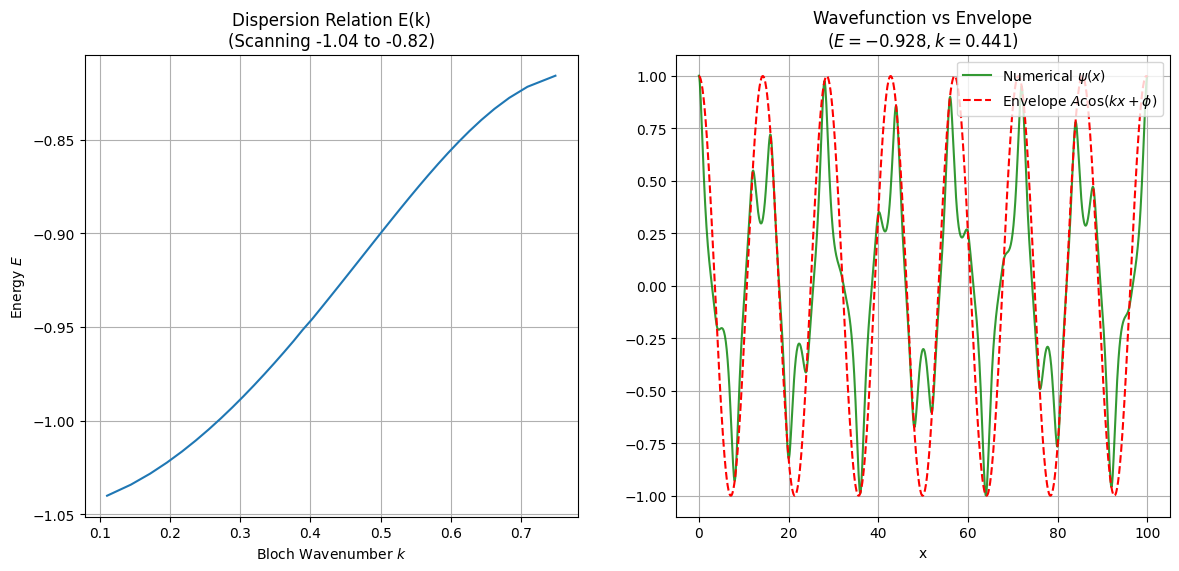

In [24]:
def plot_results(k_vals, E_vals, sol_demo, k_demo, amp_demo, phi_demo):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Dispersion
    ax1.plot(k_vals, E_vals)
    ax1.set_xlabel('Bloch Wavenumber $k$')
    ax1.set_ylabel('Energy $E$')
    ax1.set_title(f'Dispersion Relation E(k)\n(Scanning {E_vals[0]:.2f} to {E_vals[-1]:.2f})')
    ax1.grid(True)

    # Envelope Comparison
    envelope = amp_demo * np.cos(k_demo * sol_demo.t + phi_demo)

    ax2.plot(sol_demo.t, sol_demo.y[0], 'g-', alpha=0.8, label=r'Numerical $\psi(x)$')
    ax2.plot(sol_demo.t, envelope, 'r--', label=r'Envelope $A\cos(kx + \phi)$')

    ax2.set_title(f'Wavefunction vs Envelope\n($E={E_vals[len(E_vals)//2]:.3f}, k={k_demo:.3f}$)')
    ax2.set_xlabel('x')
    ax2.legend()
    ax2.grid(True)

    plt.show()

def fit_for_visualisation(sol, a):
    L = 2*a
    x_lat, psi_lat = sample_at_lattice_points(sol, a)
    def model(x, k, A, phi): return A * np.cos(k*x + phi)
    exact_k = calculate_k_exactly(sol, a)
    if exact_k is None: exact_k = np.pi/L/2

    try:
        p0 = [exact_k, 1.0, 0.0]
        bounds = ([exact_k*0.99, -np.inf, -np.pi], [exact_k*1.01, np.inf, np.pi])
        params, _ = curve_fit(model, x_lat, psi_lat, p0=p0, bounds=bounds)
        return params[0], params[1], params[2]
    except:
        return exact_k, 1.0, 0.0

a = 2.0
energies = np.linspace(-1.04, -0.81, 40)
k_vals, E_vals = get_dispersion_relation(energies, a)
E_demo = E_vals[len(E_vals)//2]
sol_demo = solve_wavefunction(E_demo, a, x_max=100)
k_vis, amp_vis, phi_vis = fit_for_visualisation(sol_demo, a)
plot_results(k_vals, E_vals, sol_demo, k_vis, amp_vis, phi_vis)

The formula
\begin{equation}
    \cos(kL) = \frac{\psi(0) + \psi(2L)}{2\psi(L)}
\end{equation}
 comes directly from the property that the wavefunction is a linear combination of Bloch functions.

The energy $E$ increases smoothly as the wavenumber $k$ increases. This is typical for a band as higher momentum corresponds to higher energy. At the lower end, the curve looks like a parabola. This indicates that for low momenta, the electron behaves somewhat like a free particle with an effective mass. As $k$ approaches the right side, known as the Brillouin Zone, the curve starts to flatten out. This indicates that the electron slows down as it reaches the band edge, eventually becoming a standing wave with zero group velocity.

The Bloch envelope connects the peaks of the green wavefunction at regular intervals. This proves that the solution is of the form of a linear combination of the envelope $\cos(kx + \phi)$ multiplied by a periodic function $u$.

In [26]:
def scan_band(energy_range, a):
    '''
    Generates (k, E) data points for a given energy range.
    '''
    k_vals = []
    E_vals = []
    # We simulate three periods to extract k
    L = get_lattice_period(a)
    x_max_sim = 3 * L

    for E in energy_range:
        sol = solve_ivp(
            fun=lambda x, y: schrodinger_system(x, y, E, a),
            t_span=(0, x_max_sim), y0=[1.0, 0.0],
            method='RK45', rtol=1e-7
        )
        k = calculate_k_exactly(sol, a)
        if k is not None:
            k_vals.append(k)
            E_vals.append(E)

    return np.array(k_vals), np.array(E_vals)

def model_tight_binding(k, E0, gamma):
    '''
    E(k) = E0 - 2*gamma*cos(k*L)
    '''
    L = 4.0 # 2*a where a=2
    return E0 - 2 * gamma * np.cos(k * L)

def model_nearly_free(k, A, B):
    '''
    E(k) = A + B*k^2 (Parabola)
    '''
    return A + B * k**2

def fit_and_score(model_func, k_data, E_data):
    '''
    Fits a model and calculates the R-squared score (1.0 is perfect).
    '''
    try:
        popt, _ = curve_fit(model_func, k_data, E_data)
        residuals = E_data - model_func(k_data, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((E_data - np.mean(E_data))**2)
        r_squared = 1 - (ss_res / ss_tot)
        return popt, r_squared
    except:
        return None, -999

In [51]:
def compare_models_for_band(band_name, energy_range, a):
    k, E = scan_band(energy_range, a)

    if len(k) < 5:
        print(f"Not enough data found for {band_name}. Check ranges.")
        return

    sort_idx = np.argsort(k)
    k = k[sort_idx]
    E = E[sort_idx]

    popt_tb, r2_tb = fit_and_score(model_tight_binding, k, E)
    popt_nf, r2_nf = fit_and_score(model_nearly_free, k, E)

    plt.figure(figsize=(8, 5))
    plt.plot(k, E, 'k', label='Numerical Data')

    if popt_tb is not None:
        plt.plot(k, model_tight_binding(k, *popt_tb), 'b-',
                 label=f'Tight Binding ($R^2={r2_tb:.4f}$)')

    if popt_nf is not None:
        plt.plot(k, model_nearly_free(k, *popt_nf), 'r--',
                 label=f'Nearly Free ($R^2={r2_nf:.4f}$)')

    plt.title(f"Model Comparison: {band_name}")
    plt.xlabel("Wavenumber k")
    plt.ylabel("Energy E")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Analysis for {band_name}")
    print(f"Tight Binding Score: {r2_tb:.5f}")
    print(f"Nearly Free Score:   {r2_nf:.5f}")

# Final Even Boundaries: [np.float64(-1.04), np.float64(-0.81), np.float64(0.3), np.float64(1.7), np.float64(1.78)]
a = 2.0

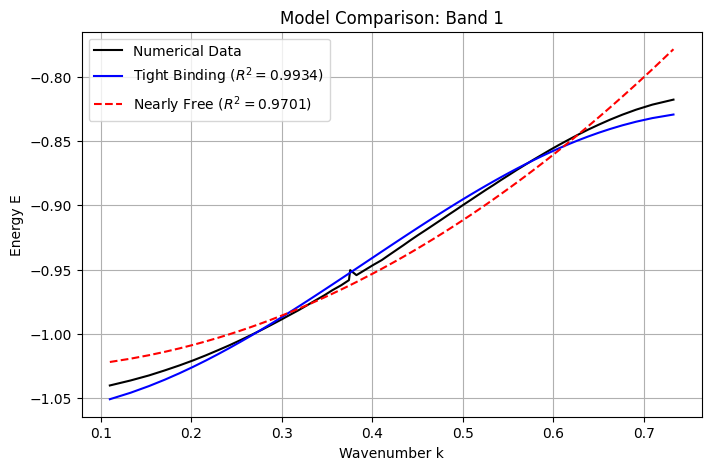

Analysis for Band 1
Tight Binding Score: 0.99337
Nearly Free Score:   0.97010


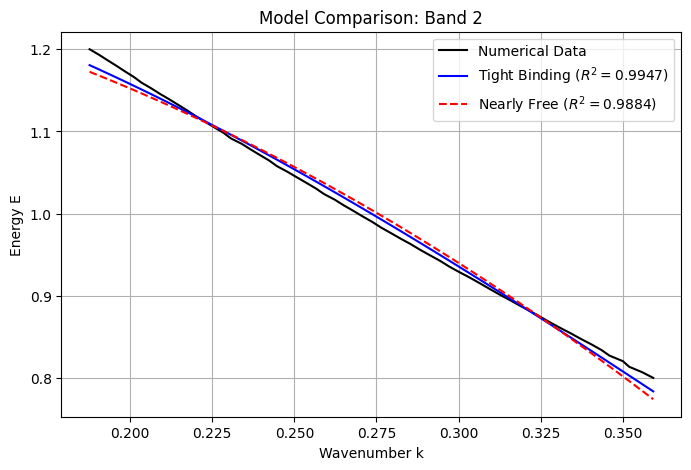

Analysis for Band 2
Tight Binding Score: 0.99473
Nearly Free Score:   0.98844


In [71]:
range_band1 = np.linspace(-1.04, -0.81, 60)
compare_models_for_band("Band 1", range_band1, a)
range_band2 = np.linspace(0.8, 1.2, 60)
compare_models_for_band("Band 2", range_band2, a)

The tight binding model fits better when the energy to wavenumber plot is not flat whereas the nearly free model parabola fits better otherwise. This confirms the expected behaviour transition of the electron as it transitions from the left end of the band to the right end.

In the low energy regime, the energy of the electron is significantly lower than the height of the potential barriers. Thus, the most appropriate model is tight binding and the region of validity is the entire Brillouin zone. At low energies, the electronics are trapped inside the potential wells of the individual lattice sites and resemble atomic orbitals. The electron can only move through the lattice by quantum tunneling through the barriers which corresponds to the weak overlap of atomic wavefunctions.

In the high energy regime, the energy of the electron is greater than the potential barriers. Here, the kinetic energy dominates the potential energy. The most appropriate model is the nearly free electron and is valid near the center of the zone where $k$ is far from the Bragg planes, $k \approx 0$. The electron travels near-parabolically through the crystal like a free particle and the lattice potential only acts as a weak perturbation. However, as $k$ approaches the Brillouin zone edge, the electron wave satisfies the condition for Bragg diffraction. The wave reflects off the lattice, creating standing waves and opening an energy gap.